In [2]:
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib notebook

from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
from scipy.constants.constants import C2F
from scipy.constants.constants import F2C

from Libraries import thermodynamics as thermo

In [3]:
n_x = 51
n_y = 51

x = np.linspace(0,10,n_x)
y = np.linspace(0,2,n_y)

X,Y = np.meshgrid(x,y)

d_x = x[1]-x[0]
d_y = y[1]-y[0]

d_t = 0.1

air = thermo.FluidArray((n_y+2,n_x+2))
air.Fluid('air')

T_o = 300.
T_b = 320.
T_t = 280.
T_r = T_o

In [11]:
def Step(steps,ny,nx,dy,dx,dt,To,Tb,Tt,T_ref):
    g = 9.8 #m/s^2
    uo = 0.01
    vo = 0.
    
    T = np.full((ny+2,nx+2),To)
    u = np.full((ny+2,nx+2),uo)
    v = np.full((ny+2,nx+2),vo)
    
    T[:,0], T[:,-1], T[0,:], T[-1,:] = T[:,-2], T[:,1], Tb, Tt

    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

    v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0
    
    c = 0
    while c<steps:
        Tn = np.copy(T)
        un = np.copy(u)
        vn = np.copy(v)
        
        air.get_properties(Tn)
        beta = air.beta
        rho = air.rho
        mu = air.mu
        alpha = air.alpha
        
        T[1:-1,1:-1] = (Tn[1:-1,1:-1]*dx**2*dy**2 + dt*un[1:-1,1:-1]*dx*dy**2*(-Tn[1:-1,2:] + Tn[1:-1,:-2])/2 + \
                        dt*dx**2*vn[1:-1,1:-1]*dy*(-Tn[2:,1:-1] + Tn[:-2,1:-1])/2 + dt*dx**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1]\
                        + Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dy**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + Tn[1:-1,2:] + \
                                                                                   Tn[1:-1,:-2]))/(dx**2*dy**2)
        
        u[1:-1,1:-1] = (un[1:-1,1:-1]*dt*dx*dy**2*rho[1:-1,1:-1]*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                        un[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*dx**2*vn[1:-1,1:-1]*dy*rho[1:-1,1:-1]*(-un[2:,1:-1] + \
                        un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,:-2] + un[1:-1,2:]))/(dx**2*dy**2*rho[1:-1,1:-1])
        
        v[1:-1,1:-1] = (vn[1:-1,1:-1]*dt*dx**2*dy*rho[1:-1,1:-1]*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                        dt*un[1:-1,1:-1]*dx*dy**2*rho[1:-1,1:-1]*(-vn[1:-1,2:] + vn[1:-1,:-2])/2 + \
                        dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + vn[:-2,1:-1]) + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,:-2] + vn[1:-1,2:]) + \
                        dx**2*dy**2*rho[1:-1,1:-1]*(vn[1:-1,1:-1] - dt*g*beta[1:-1,1:-1]*Tn[1:-1,1:-1] + \
                                                    dt*g*beta[1:-1,1:-1]*T_ref))/(dx**2*dy**2*rho[1:-1,1:-1])
        c+=1
    return u,v,T     

<IPython.core.display.Javascript object>


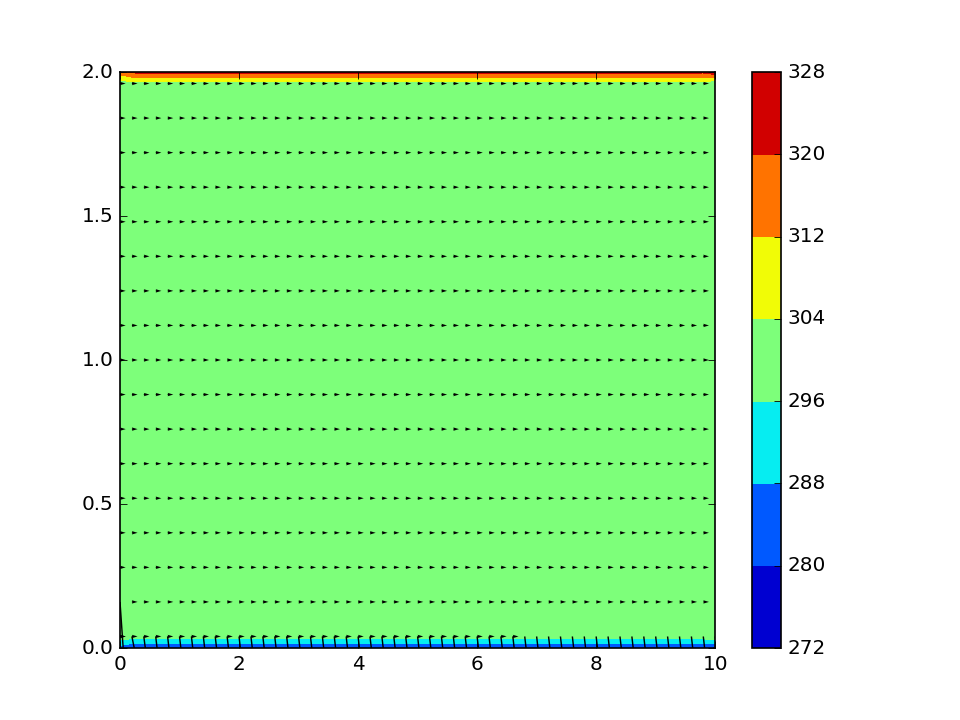

In [12]:
U,V,Temp = Step(150,n_y,n_x,d_y,d_x,d_t,T_o,T_b,T_t,T_r)

fig = pl.figure(dpi=120)
ax = pl.axes()
pl.contourf(X,Y,Temp[1:-1,1:-1])
pl.colorbar()
pl.quiver(X[1:-1:3],Y[1:-1:3],U[1:-1:3],V[1:-1:3])